# How to Use Backpropagation to Train a Feedforward NN

### Loading Libraries

In [5]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Warnings
import warnings

# Path
from pathlib import Path
from copy import deepcopy

# Data Visualizaion
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib.colors import ListedColormap

# Scikit-Learn
import sklearn
from sklearn.datasets import make_circles

In [6]:
np.random.seed(seed=42)

sns.set_style('white')

warnings.filterwarnings('ignore')

pd.set_option('display.expand_frame_repr', False)

In [7]:
results_path = Path('results')

if not results_path.exists():
    results_path.mkdir()

### Input Data

#### Generating Random Data

In [8]:
N = 50000

factor = 0.1
noise = 0.1

In [9]:
n_iterations = 50000

learning_rate = 0.0001

momentum_factor = .5

In [10]:
X, y = make_circles(
    n_samples=N,
    shuffle=True,
    factor=factor,
    noise=noise)

In [11]:
Y = np.zeros((N, 2))

for c in [0, 1]:
    Y[y == c, c] = 1

In [12]:
f'Shape of: X: {X.shape} | Y: {Y.shape} | y: {y.shape}'

'Shape of: X: (50000, 2) | Y: (50000, 2) | y: (50000,)'

### Visualizing Data

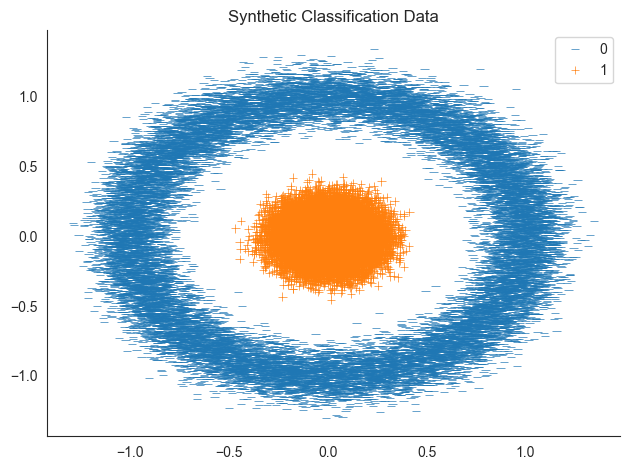

In [13]:
ax = sns.scatterplot(x=X[:, 0], 
                y=X[:, 1], 
                hue=y,
               style=y,
               markers=['_', '+'])

ax.set_title('Synthetic Classification Data')
sns.despine()
plt.tight_layout()
plt.savefig(results_path / 'ffnn_data', dpi=300);
plt.show()

### Neural Network Architecture

#### Hidden Layer Activations

In [14]:
def logistic(z):
    """Logistic function."""
    return 1 / (1 + np.exp(-z))

In [15]:
def hidden_layer(input_data, weights, bias):
    """Compute hidden activations"""
    return logistic(input_data @ weights + bias)

#### Output Activations

In [16]:
def softmax(z):
    """Softmax function"""
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

In [17]:
def output_layer(hidden_activations, weights, bias):
    """Compute the output y_hat"""
    return softmax(hidden_activations @ weights + bias)

#### Forward Propagation

In [18]:
def forward_prop(data, hidden_weights, hidden_bias, output_weights, output_bias):
    """Neural network as function."""
    hidden_activations = hidden_layer(data, hidden_weights, hidden_bias)
    return output_layer(hidden_activations, output_weights, output_bias)

In [19]:
def predict(data, hidden_weights, hidden_bias, output_weights, output_bias):
    """Predicts class 0 or 1"""
    y_pred_proba = forward_prop(data,
                                hidden_weights,
                                hidden_bias,
                                output_weights,
                                output_bias)
    return np.around(y_pred_proba)

#### Cross-Entropy Loss

In [20]:
def loss(y_hat, y_true):
    """Cross-entropy"""
    return - (y_true * np.log(y_hat)).sum()

### Backpropagation

#### Loss Function Gradient

In [21]:
def loss_gradient(y_hat, y_true):
    """output layer gradient"""
    return y_hat - y_true

### Output Layer Gradients

#### Output Weight Gradients

In [22]:
def output_weight_gradient(H, loss_grad):
    """Gradients for the output layer weights"""
    return  H.T @ loss_grad

In [23]:
def output_bias_gradient(loss_grad):
    """Gradients for the output layer bias"""
    return np.sum(loss_grad, axis=0, keepdims=True)

### Hidden Layer Gradients

In [24]:
def hidden_layer_gradient(H, out_weights, loss_grad):
    """Error at the hidden layer.
    H * (1-H) * (E . Wo^T)"""
    return H * (1 - H) * (loss_grad @ out_weights.T)

#### Hidden Weight Gradient

In [25]:
def hidden_weight_gradient(X, hidden_layer_grad):
    """Gradient for the weight parameters at the hidden layer"""
    return X.T @ hidden_layer_grad

#### Hidden Bias Gradient

In [26]:
def hidden_bias_gradient(hidden_layer_grad):
    """Gradient for the bias parameters at the output layer"""
    return np.sum(hidden_layer_grad, axis=0, keepdims=True)

### Initialize Weights

In [27]:
def initialize_weights():
    """Initialize hidden and output weights and biases"""

    # Initialize hidden layer parameters
    hidden_weights = np.random.randn(2, 3)
    hidden_bias = np.random.randn(1, 3)

    # Initialize output layer parameters
    output_weights = np.random.randn(3, 2)
    output_bias = np.random.randn(1, 2)
    return hidden_weights, hidden_bias, output_weights, output_bias

### Computing Gradients

In [28]:
def compute_gradients(X, y_true, w_h, b_h, w_o, b_o):
    """Evaluate gradients for parameter updates"""

    # Compute hidden and output layer activations
    hidden_activations = hidden_layer(X, w_h, b_h)
    y_hat = output_layer(hidden_activations, w_o, b_o)

    # Compute the output layer gradients
    loss_grad = loss_gradient(y_hat, y_true)
    out_weight_grad = output_weight_gradient(hidden_activations, loss_grad)
    out_bias_grad = output_bias_gradient(loss_grad)

    # Compute the hidden layer gradients
    hidden_layer_grad = hidden_layer_gradient(hidden_activations, w_o, loss_grad)
    hidden_weight_grad = hidden_weight_gradient(X, hidden_layer_grad)
    hidden_bias_grad = hidden_bias_gradient(hidden_layer_grad)

    return [hidden_weight_grad, hidden_bias_grad, out_weight_grad, out_bias_grad]

### Checking Gradients

In [29]:
eps = 1e-4

# initialize weights and biases
params = initialize_weights()

# Get all parameter gradients
grad_params = compute_gradients(X, Y, *params)

# Check each parameter matrix
for i, param in enumerate(params):
    # Check each matrix entry
    rows, cols = param.shape
    for row in range(rows):
        for col in range(cols):
            # change current entry by +/- eps
            params_low = deepcopy(params)
            params_low[i][row, col] -= eps

            params_high = deepcopy(params)
            params_high[i][row, col] += eps

            # Compute the numerical gradient
            loss_high = loss(forward_prop(X, *params_high), Y)
            loss_low = loss(forward_prop(X, *params_low), Y)
            numerical_gradient = (loss_high - loss_low) / (2 * eps)

            backprop_gradient = grad_params[i][row, col]
            
            # Raise error if numerical and backprop gradient differ
            assert np.allclose(numerical_gradient, backprop_gradient), ValueError(
                    f'Numerical gradient of {numerical_gradient:.6f} not close to '
                    f'backprop gradient of {backprop_gradient:.6f}!')

print('No gradient errors found')

No gradient errors found


### Training Network

In [30]:
def update_momentum(X, y_true, param_list,
                    Ms, momentum_term,
                    learning_rate):
    """Update the momentum matrices."""
    # param_list = [hidden_weight, hidden_bias, out_weight, out_bias]
    # gradients = [hidden_weight_grad, hidden_bias_grad,
    #               out_weight_grad, out_bias_grad]
    gradients = compute_gradients(X, y_true, *param_list)
    return [momentum_term * momentum - learning_rate * grads
            for momentum, grads in zip(Ms, gradients)]

In [31]:
def update_params(param_list, Ms):
    """Update the parameters."""
    # param_list = [Wh, bh, Wo, bo]
    # Ms = [MWh, Mbh, MWo, Mbo]
    return [P + M for P, M in zip(param_list, Ms)]

In [32]:
def train_network(iterations=1000, lr=.01, mf=.1):
    # Initialize weights and biases
    param_list = list(initialize_weights())

    # Momentum Matrices = [MWh, Mbh, MWo, Mbo]
    Ms = [np.zeros_like(M) for M in param_list]

    train_loss = [loss(forward_prop(X, *param_list), Y)]
    for i in range(iterations):
        if i % 1000 == 0: print(f'{i:,d}', end=' ', flush=True)
        # Update the moments and the parameters
        Ms = update_momentum(X, Y, param_list, Ms, mf, lr)

        param_list = update_params(param_list, Ms)
        train_loss.append(loss(forward_prop(X, *param_list), Y))

    return param_list, train_loss

In [34]:
# n_iterations = 20000

# results = {}

# for learning_rate in [.01, .02, .05, .1, .25]:
#     for momentum_factor in [0, .01, .05, .1, .5]:
#         print(learning_rate, momentum_factor)
#         trained_params, train_loss = train_network(iterations=n_iterations, lr=learning_rate, mf=momentum_factor)
#         results[(learning_rate, momentum_factor)] = train_loss[::1000]

In [35]:
trained_params, train_loss = train_network(iterations=n_iterations, 
                                           lr=learning_rate, 
                                           mf=momentum_factor)

0 1,000 2,000 3,000 4,000 5,000 6,000 7,000 8,000 9,000 10,000 11,000 12,000 13,000 14,000 15,000 16,000 17,000 18,000 19,000 20,000 21,000 22,000 23,000 24,000 25,000 26,000 27,000 28,000 29,000 30,000 31,000 32,000 33,000 34,000 35,000 36,000 37,000 38,000 39,000 40,000 41,000 42,000 43,000 44,000 45,000 46,000 47,000 48,000 49,000 

In [36]:
hidden_weights, hidden_bias, output_weights, output_bias = trained_params

#### Plotting Training Loss

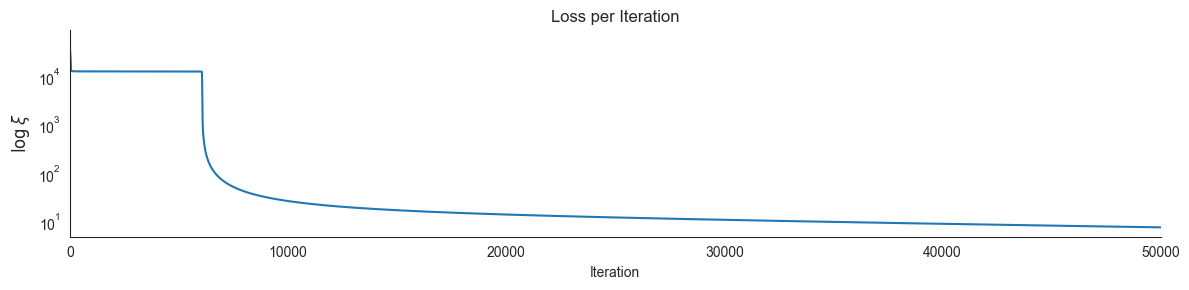

In [37]:
ax = pd.Series(train_loss).plot(figsize=(12, 3), title='Loss per Iteration', xlim=(0, n_iterations), logy=True)

ax.set_xlabel('Iteration')
ax.set_ylabel('$\\log \\xi$', fontsize=12)
sns.despine()
plt.tight_layout()
plt.savefig(results_path / 'ffnn_loss', dpi=300)
plt.show()

#### Decision Boundary

In [38]:
n_vals = 200

x1 = np.linspace(-1.5, 1.5, num=n_vals)
x2 = np.linspace(-1.5, 1.5, num=n_vals)
xx, yy = np.meshgrid(x1, x2)  # create the grid

# Initialize and fill the feature space
feature_space = np.zeros((n_vals, n_vals))
for i in range(n_vals):
    for j in range(n_vals):
        X_ = np.asarray([xx[i, j], yy[i, j]])
        feature_space[i, j] = np.argmax(predict(X_, *trained_params))

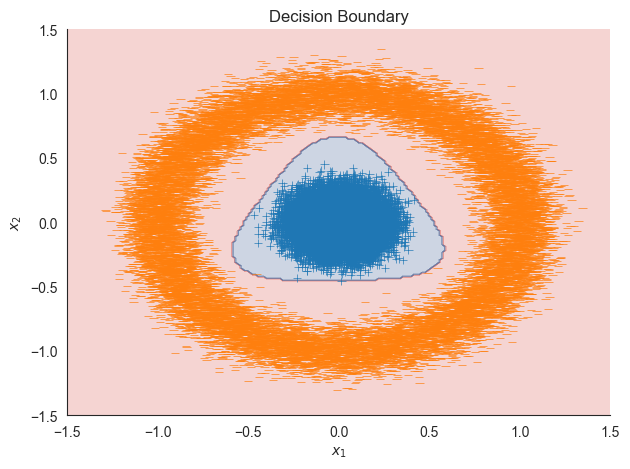

In [39]:
cmap = ListedColormap([sns.xkcd_rgb["pale red"],
                       sns.xkcd_rgb["denim blue"]])

plt.contourf(xx, yy, feature_space, cmap=cmap, alpha=.25)

data = pd.DataFrame(X, columns=['$x_1$', '$x_2$']).assign(Class=pd.Series(y).map({0:'negative', 1:'positive'}))
sns.scatterplot(x='$x_1$', y='$x_2$', hue='Class', data=data, style=y, markers=['_', '+'], legend=False)
plt.title('Decision Boundary')
sns.despine()
plt.tight_layout()
plt.savefig(results_path / 'boundary', dpi=300);
plt.show()

### Projection on Hidden Layer

In [40]:
n_vals = 25

x1 = np.linspace(-1.5, 1.5, num=n_vals)
x2 = np.linspace(-1.5, 1.5, num=n_vals)
xx, yy = np.meshgrid(x1, x2)  

X_ = np.array([xx.ravel(), yy.ravel()]).T

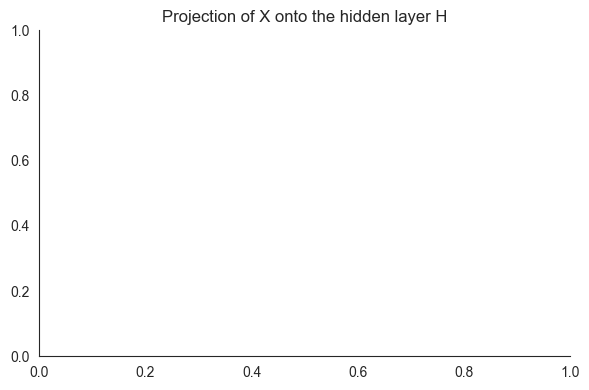

In [41]:
fig = plt.figure(figsize=(6, 4))

with sns.axes_style("whitegrid"):
    ax = Axes3D(fig)

ax.plot(*hidden_layer(X[y == 0], hidden_weights, hidden_bias).T,
        '_', label='negative class', alpha=0.75)
ax.plot(*hidden_layer(X[y == 1], hidden_weights, hidden_bias).T,
        '+', label='positive class', alpha=0.75)

ax.set_xlabel('$h_1$', fontsize=12)
ax.set_ylabel('$h_2$', fontsize=12)
ax.set_zlabel('$h_3$', fontsize=12)
ax.view_init(elev=30, azim=-20)
# plt.legend(loc='best')
plt.title('Projection of X onto the hidden layer H')
sns.despine()
plt.tight_layout()
plt.savefig(results_path / 'projection3d', dpi=300)
plt.show()

### Network Output Surface Plot

In [42]:
zz = forward_prop(X_, hidden_weights, hidden_bias, output_weights, output_bias)[:, 1].reshape(25, -1)
zz.shape

(25, 25)

In [44]:
# fig = plt.figure()

# with sns.axes_style("whitegrid"):
#     ax = fig.gca(projection='3d')
# ax.plot_surface(xx, yy, zz, alpha=.25)
# ax.set_title('Learned Function')
# ax.set_xlabel('$x_1$', fontsize=12)
# ax.set_ylabel('$x_2$', fontsize=12)
# ax.set_zlabel('$y$', fontsize=12)
# ax.view_init(elev=45, azim=-20)
# sns.despine()
# fig.tight_layout()
# fig.savefig(results_path / 'surface', dpi=300);
# plt.show()

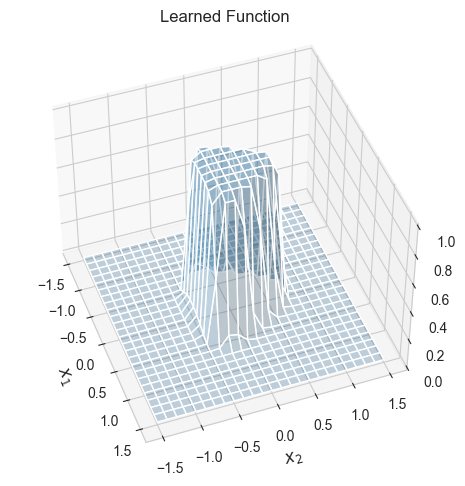

In [46]:
fig = plt.figure()

with sns.axes_style("whitegrid"):
    ax = fig.add_subplot(111, projection='3d')  
    
ax.plot_surface(xx, yy, zz, alpha=.25)
ax.set_title('Learned Function')
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)
ax.set_zlabel('$y$', fontsize=12)
ax.view_init(elev=45, azim=-20)
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'surface', dpi=300)
plt.show()